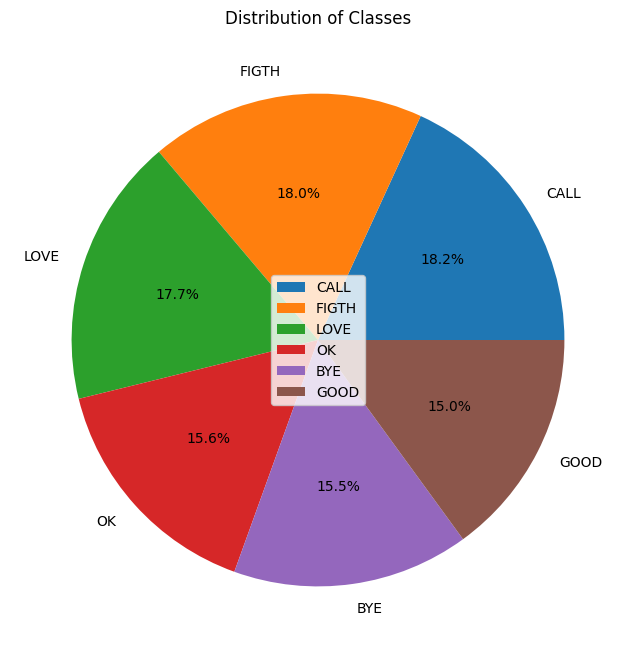

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv('/home/hankla/Desktop/work/clas_hands/train/data_landmark_hands.csv')

# Extract the 'class' column as the target variable
clas = data['class']

# Extract the landmark columns as features
data_input = np.array([[data[f'Landmark_{i}'][x] for i in range(21)] for x in range(len(data['Landmark_0']))])

# Map target labels to class names
class_names = {0: 'BYE', 1: 'GOOD', 2: 'FIGTH', 3: 'OK', 4: 'LOVE', 5: 'CALL'}

# Plotting a pie chart with class names
class_counts = clas.value_counts()
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=[class_names[i] for i in class_counts.index], autopct='%1.1f%%')
plt.title('Distribution of Classes')
plt.legend(loc='center')
plt.show()

# Map target labels to one-hot encoding
target_labels = {i: np.eye(6)[i] for i in range(6)}
target = np.array([target_labels[label] for label in clas])

# Convert data to PyTorch tensors
data_input = torch.tensor(data_input, dtype=torch.float32)
target = torch.tensor(target, dtype=torch.float32)

# Split the data into training and testing sets
train_size = int(0.8 * len(data_input))
test_size = len(data_input) - train_size

X_train, X_test = data_input[:train_size], data_input[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# Define your neural network
input_size = X_train.shape[1]  # Adjust based on your actual input size



In [5]:
class SimpleNN(torch.nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        hidden_size1 = 64
        hidden_size2 = 32
        output_size = 6

        self.fc1 = torch.nn.Linear(input_size, hidden_size1)
        self.fc2 = torch.nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = torch.nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

/home/hankla/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/500, Train Loss: 1.5094488494065932, Train Accuracy: 0.43341753879465894, Test Loss: 2.1007534512158097, Test Accuracy: 0.0
Epoch 2/500, Train Loss: 0.9194239966926121, Train Accuracy: 0.6708769397329484, Test Loss: 1.6791245418375935, Test Accuracy: 0.03607503607503607
Epoch 3/500, Train Loss: 0.6899261957768238, Train Accuracy: 0.7618188379646337, Test Loss: 1.392682532811987, Test Accuracy: 0.1370851370851371
Epoch 4/500, Train Loss: 0.5278669444287752, Train Accuracy: 0.8740526885600867, Test Loss: 1.6467308859372962, Test Accuracy: 0.14574314574314573
Epoch 5/500, Train Loss: 0.3939109994219495, Train Accuracy: 0.9123060267051606, Test Loss: 1.746421506901368, Test Accuracy: 0.2178932178932179
Epoch 6/500, Train Loss: 0.32372701889331335, Train Accuracy: 0.9162757127390834, Test Loss: 1.4505321462638676, Test Accuracy: 0.20202020202020202
Epoch 7/500, Train Loss: 0.2860439005952925, Train Accuracy: 0.9184409960303139, Test Loss: 1.3787821692350353, Test Accuracy: 0.2279942

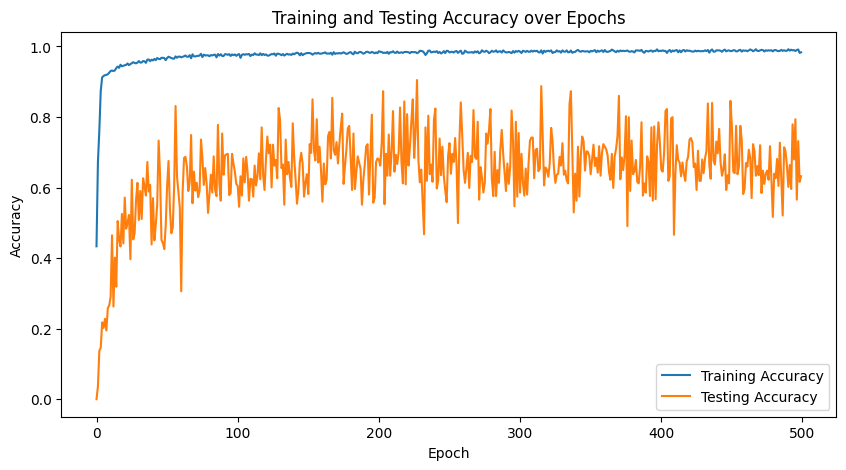

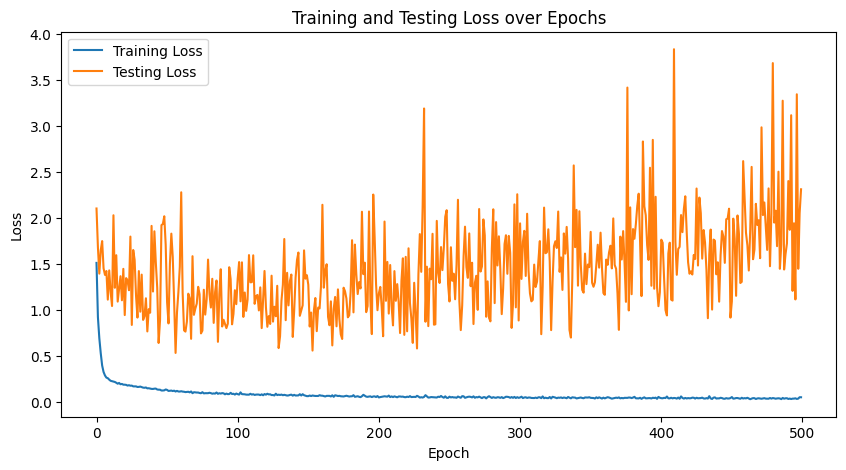

In [6]:
model = SimpleNN(input_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For classification tasks
optimizer = optim.Adam(model.parameters())  # Adjust the learning rate as needed

# Create a TensorDataset and a DataLoader for training data
train_dataset = TensorDataset(X_train, y_train)
batch_size = 6
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a TensorDataset and a DataLoader for testing data
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle for testing

# Training loop
num_epochs = 500

train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []

for epoch in range(num_epochs):
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training
    model.train()  # Set the model to training mode
    for inputs, labels in train_dataloader:
        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, torch.argmax(labels, dim=1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_train_loss += loss.item()

        # Compute training accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == torch.argmax(labels, dim=1)).sum().item()

    # Calculate average training loss and accuracy for the epoch
    epoch_train_loss = running_train_loss / len(train_dataloader)
    epoch_train_accuracy = correct_train / total_train

    # Store training accuracy and loss values
    train_accuracy.append(epoch_train_accuracy)
    train_loss.append(epoch_train_loss)

    # Testing
    model.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, torch.argmax(labels, dim=1))

            # Accumulate loss
            running_test_loss += loss.item()

            # Compute testing accuracy
            _, predicted_test = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted_test == torch.argmax(labels, dim=1)).sum().item()

    # Calculate average testing loss and accuracy for the epoch
    epoch_test_loss = running_test_loss / len(test_dataloader)
    epoch_test_accuracy = correct_test / total_test

    # Store testing accuracy and loss values
    test_accuracy.append(epoch_test_accuracy)
    test_loss.append(epoch_test_loss)

    # Print the loss and accuracy after each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss}, Train Accuracy: {epoch_train_accuracy}, Test Loss: {epoch_test_loss}, Test Accuracy: {epoch_test_accuracy}')

# Plotting training and testing accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()
plt.show()

# Plotting training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.show()